<a href="https://colab.research.google.com/github/tcotte/CNN_Pytorch/blob/master/Optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Optimizers

In [1]:
!git clone https://github.com/tcotte/CNN_Pytorch
%cd CNN_Pytorch

fatal: destination path 'CNN_Pytorch' already exists and is not an empty directory.
/content/CNN_Pytorch


In [2]:
import numpy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)
device = torch.device("cuda" if cuda else "cpu")

if cuda:
    torch.cuda.manual_seed(SEED)

We are going to use the alex architecture and try different optimizers on this notebook.

In [3]:
from torchvision import transforms

AlexTransform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

### Load Dataset

In [4]:
import os
import torchvision

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

batch_size=256
dataset_dir = os.path.join(os.path.expanduser("~"), 'Datasets', 'FashionMNIST')

# Load the dataset for alexnet arch
train_dataset = torchvision.datasets.FashionMNIST(root=dataset_dir,
                                           train=True,
                                           transform= AlexTransform,
                                           download=True)

test_dataset = torchvision.datasets.FashionMNIST(root=dataset_dir,
                                           train=False,
                                           transform= AlexTransform,
                                           download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,                
                                          num_workers=4)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,                
                                          num_workers=4)

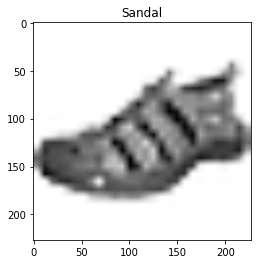

In [5]:
from functions.plot_picture import matplotlib_imshow

# get some random training images
dataiter = iter(train_loader)

images, labels = dataiter.next()

# # creat grid of images
img_grid = torchvision.utils.make_grid(images[0])

# # show images & labels
matplotlib_imshow(img_grid, class_names[labels[0]])

In [6]:
from functions.training import train_model, evaluate_model
from models.alexnet_arch import AlexNet
from models.lenet_arch import Model_Type_LeNet
import torch.optim as optim

EPOCHS = 10
losses_an = []
accuracies_an = []
nb_batch = int(np.ceil(len(train_loader.dataset)/batch_size))

alexnet_model = AlexNet()

optimizers = {"SGD": optim.SGD(alexnet_model.parameters(),  lr=0.001),
             "AdamW": optim.AdamW(alexnet_model.parameters(),  lr=0.001),
            #  "Adagrad": optim.Adagrad(alexnet_model.parameters(),  lr=0.001),
             "Adam": optim.Adam(alexnet_model.parameters(),  lr=0.001)
}

alexnet_model.to(device)
for opt in optimizers:
  print("<================ "+opt+" ================>")
  for epoch in range(EPOCHS):
    losses_an.extend(train_model(train_loader, device, alexnet_model, optimizers[opt], epoch,  EPOCHS, batch_size)[-nb_batch:])
    accuracies_an.append(evaluate_model(alexnet_model, device, test_loader, losses_an[-1], EPOCHS, epoch, batch_size, len(train_loader.dataset)))

<================ SGD ================>


KeyboardInterrupt: ignored

In [7]:
device

device(type='cpu')

In [ ]:
rest_optimizers = {
             "Adam": optim.Adam(alexnet_model.parameters(),  lr=0.001)
             }

for opt in rest_optimizers:
  print("<================ "+opt+" ================>")
  for epoch in range(EPOCHS):
    losses_an.extend(train_model(train_loader, device, alexnet_model, optimizers[opt], epoch,  EPOCHS, batch_size)[-nb_batch:])
    accuracies_an.append(evaluate_model(alexnet_model, device, test_loader, losses_an[-1], EPOCHS, epoch, batch_size, len(train_loader.dataset)))

### Register in csv file

In [ ]:
def filter_losses(losses, EPOCHS):
  losses_filtered = []
  for i in range(EPOCHS):
    if i==0:
      losses_filtered.append(losses[nb_batch-1])
    else:
      losses_filtered.append(losses[nb_batch-1+nb_batch*i])
  return losses_filtered

In [ ]:
import pandas as pd 

d = {('SGD', 'accuracy'): accuracies_an[:10],
     ('SGD', 'loss'): filter_losses(losses_an[:2350], EPOCHS),
     ('AdamW','accuracy'): accuracies_an[10:20],
     ('AdamW','loss'): filter_losses(losses_an[2350:2350*2], EPOCHS),
     ('Adam','accuracy'): accuracies_an[20:],
     ('Adam','loss'): filter_losses(losses_an[2350*2:], EPOCHS),
}
l=[('SGD', 'accuracy'),  ('SGD', 'loss'), ('AdamW','accuracy'),  ('AdamW','loss'), ('Adam','accuracy'),  ('Adam','loss')]
df = pd.DataFrame(data=d, columns = l)

df.columns = pd.MultiIndex.from_tuples(df.columns, names=['',''])
df

In [ ]:
df.to_csv('csv/different_optimizers.csv')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15,6))

ax1.plot(np.arange(EPOCHS), df[('SGD', 'accuracy')], label='SGD')
ax1.plot(np.arange(EPOCHS), df[('AdamW', 'accuracy')], label='AdamW')
ax1.plot(np.arange(EPOCHS), df[('Adam', 'accuracy')], label='Adam')
# ax2.plot(np.arange(EPOCHS), df[('SGD', 'loss')], label='SGD')
# ax2.plot(np.arange(EPOCHS), df[('AdamW', 'loss')], label='AdamW')
# ax2.plot(np.arange(EPOCHS), df[('Adam', 'loss')], label='Adam')
ax2.plot(np.arange(2350), losses_an[:2350], label='SGD')
ax2.plot(np.arange(2350), losses_an[2350:2350*2], label='AdamW')
ax2.plot(np.arange(2350), losses_an[2350*2:], label='Adam')
ax1.set_ylim(0,1)
ax1.set_title("Test accuracy during epochs in function of optimizers")
ax2.set_title("Train loss during batch trained in function of optimizers")
plt.legend(loc='center left')

for ax in [ax1, ax2]:
  ax.set_xlabel("Epochs")

ax1.set_ylabel("Test accuracy")
ax2.set_ylabel("Train loss")

In [ ]:
optimizer = optim.AdamW(alexnet_model.parameters(),  lr=0.0001)

for epoch in range(EPOCHS):
  losses_an.extend(train_model(train_loader, device, alexnet_model, optimizer, epoch,  EPOCHS, batch_size)[-nb_batch:])
  accuracies_an.append(evaluate_model(alexnet_model, device, test_loader, losses_an[-1], EPOCHS, epoch, batch_size, len(train_loader.dataset)))